In [9]:
import pandas as pd
import numpy as np
from dsipts import TimeSeries, RNN, Attention,read_public_dataset, LinearTS, Persistent, D3VAE
import matplotlib.pyplot as plt
from datetime import timedelta
import logging
import sys


file_handler = logging.FileHandler(filename='tmp.log')
stdout_handler = logging.StreamHandler(stream=sys.stdout)
handlers = [file_handler, stdout_handler]

logging.basicConfig(
    level=logging.INFO, 
    format='[%(asctime)s] {%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
    handlers=handlers
)


In [10]:
data, columns = read_public_dataset('/home/agobbi/Projects/ExpTS/data','traffic')

[2023-05-08 15:23:15,224] {public_datasets.py:63} INFO - Dataset loaded with shape (17544, 863)


In [11]:
## reading weather dataset
## time column is the time, y is the target, the others are covariates (in the past)
data, columns = read_public_dataset('/home/agobbi/Projects/ExpTS/data','weather')

[2023-05-08 15:23:15,364] {public_datasets.py:63} INFO - Dataset loaded with shape (52696, 22)


In [12]:
data

time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0     2020-01-01 00:10:00   1008.89      0.71    273.18        -1.33    86.1   
1     2020-01-01 00:20:00   1008.76      0.75    273.22        -1.44    85.2   
2     2020-01-01 00:30:00   1008.66      0.73    273.21        -1.48    85.1   
3     2020-01-01 00:40:00   1008.64      0.37    272.86        -1.64    86.3   
4     2020-01-01 00:50:00   1008.61      0.33    272.82        -1.50    87.4   
...                   ...       ...       ...       ...          ...     ...   
52691 2020-12-31 23:20:00    978.32      2.28    277.16        -0.80    80.0   
52692 2020-12-31 23:30:00    978.30      2.13    277.01        -0.43    83.1   
52693 2020-12-31 23:40:00    978.26      1.99    276.88        -0.71    82.2   
52694 2020-12-31 23:50:00    978.26      2.07    276.95        -0.77    81.4   
52695 2021-01-01 00:00:00    978.24      2.01    276.89        -0.66    82.4   

       VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  ...  wv (m/s)  \
0              6.43          5.54          0.89       3.42  ...      1.02   
1              6.45          5.49          0.95       3.39  ...      0.43   
2              6.44          5.48          0.96       3.39  ...      0.61   
3              6.27          5.41          0.86       3.35  ...      1.11   
4              6.26          5.47          0.79       3.38  ...      0.49   
...             ...           ...           ...        ...  ...       ...   
52691          7.20          5.76          1.44       3.67  ...      0.73   
52692          7.12          5.92          1.20       3.77  ...      0.43   
52693          7.05          5.80          1.26       3.69  ...      0.38   
52694          7.09          5.77          1.32       3.68  ...      0.57   
52695          7.06          5.82          1.24       3.71  ...      0.57   

       max. wv (m/s)  wd (deg)  rain (mm)  raining (s)  SWDR (W/m�)  \
0               1.60     224.3        0.0          0.0          0.0   
1               0.84     206.8        0.0          0.0          0.0   
2               1.48     197.1        0.0          0.0          0.0   
3               1.48     206.4        0.0          0.0          0.0   
4               1.40     209.6        0.0          0.0          0.0   
...              ...       ...        ...          ...          ...   
52691           1.40     180.6        0.0          0.0          0.0   
52692           0.82     174.0        0.0          0.0          0.0   
52693           0.76     248.9        0.0          0.0          0.0   
52694           1.07     196.6        0.0          0.0          0.0   
52695           1.08     221.3        0.0          0.0          0.0   

       PAR (�mol/m�/s)  max. PAR (�mol/m�/s)  Tlog (degC)      y  
0                  0.0                   0.0        11.45  428.1  
1                  0.0                   0.0        11.51  428.0  
2                  0.0                   0.0        11.60  427.6  
3                  0.0                   0.0        11.70  430.0  
4                  0.0                   0.0        11.81  432.2  
...                ...                   ...          ...    ...  
52691              0.0                   0.0        13.40  433.0  
52692              0.0                   0.0        13.42  439.6  
52693              0.0                   0.0        13.45  435.2  
52694              0.0                   0.0        13.47  433.9  
52695              0.0                   0.0        13.48  436.5  

[52696 rows x 22 columns]

In [13]:
model_to_use = 'linear' #attention, rnn
use_covariates = False  #use only y

In [14]:
##load the timeseries to the datastructure, adding the hour column and use all the covariates
ts = TimeSeries('weather')
if model_to_use!='attention':
    ts.load_signal(data,enrich_cat=['hour'],target_variables=['y'],past_variables=columns if use_covariates else [])
else:
    ##attention will use also y in the future, using a masking mechanism
    ts.load_signal(data,enrich_cat=['hour'],target_variables=['y'],future_variables=['y'],past_variables=columns if use_covariates else [])

[2023-05-08 15:23:18,010] {data_structure.py:217} INFO - ################I will drop duplicates, I dont like them###################
[2023-05-08 15:23:18,024] {data_structure.py:221} INFO - #########There are holes in the dataset i will try to extend the dataframe inserting NAN#############3
[2023-05-08 15:23:18,025] {data_structure.py:223} INFO - #############Detected minumum frequency: 0 days 00:10:00#############
[2023-05-08 15:23:18,045] {data_structure.py:232} INFO - ##########I will update past column adding all target columns, if you want to avoid this beahviour please use check_pass as false############


In [15]:
ts.past_variables


['y']

[2023-05-08 15:23:19,914] {data_structure.py:267} INFO - plotting only target variables


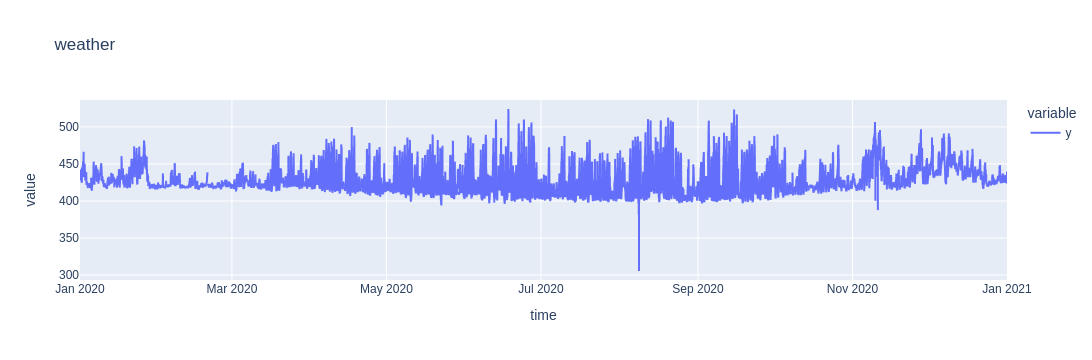

In [16]:
fig = ts.plot()

In [17]:
#Let now prepare a model predictin the next 16 step using the past 16 steps 
past_steps = 16
future_steps = 16


In [18]:
#RNN
config = dict(model_configs =dict(
                                    cat_emb_dim = 16,
                                    hidden_RNN = 18,
                                    num_layers_RNN =1,
                                    sum_emb = True,                                        #not influent here, there is only 'hour' as categorical variable
                                    kind = 'lstm',
                                    kernel_size = 5,
                                    use_bn = False,
                                    activation='selu',
                                    past_steps = past_steps,
                                    future_steps = future_steps,
                                    past_channels = len(ts.num_var),                       #parameter that depends on the ts dataset
                                    future_channels = len(ts.future_variables),            #parameter that depends on the ts dataset
                                    embs = [ts.dataset[c].nunique() for c in ts.cat_var],  #parameter that depends on the ts dataset
                                    quantiles=[0.1,0.5,0.9],                               #use quantile loss
                                    out_channels = len(ts.target_variables)),              #parameter that depends on the ts dataset
                scheduler_config = dict(gamma=0.1,step_size=100),
                optim_config = dict(lr = 0.0005,weight_decay=0.01))
model_sum = RNN(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'] )


[2023-05-08 15:23:22,944] {RNN.py:96} INFO - Using sum


/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning:

Initializing zero-element tensors is a no-op



In [19]:

config = dict(model_configs =dict(
                                    past_channels = len(ts.num_var),
                                    future_channels = len(ts.future_variables),
                                    d_model = 128,
                                    cat_emb_dim = 16,
                                    num_heads = 8,
                                    dropout = 0.5,
                                    n_layer_encoder = 6,
                                    n_layer_decoder  = 3,
                                    past_steps = past_steps,
                                    future_steps = future_steps,
                            
                                    embs = [ts.dataset[c].nunique() for c in ts.cat_var],
                                    quantiles= [0.1,0.5,0.9],
                                    out_channels= len(ts.target_variables)),
                    scheduler_config = dict(gamma=0.1,step_size=100),
                    optim_config = dict(lr = 0.0005,weight_decay=0.2))
model_sum = Attention(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'] )


In [20]:


config = dict(model_configs =dict(
                                    past_steps = past_steps,
                                    future_steps = future_steps,
                                    past_channels = len(ts.num_var),
                                    future_channels = len(ts.future_variables),
                                    embs = [ts.dataset[c].nunique() for c in ts.cat_var],
                                    cat_emb_dim = 8,
                                    kernel_size = 3,
                                     use_bn = False,
                                    activation='selu',
                                     sum_emb = True,
                                     out_channels = len(ts.target_variables),
                                    hidden_size = 256,
                                    kind='nlinear',
                                    quantiles= [0.1,0.5,0.9],
    
                                    ),
                scheduler_config = dict(gamma=0.1,step_size=24),
                optim_config = dict(lr = 0.0005,weight_decay=0.01))
model_sum = LinearTS(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'] )


[2023-05-08 15:23:26,832] {LinearTS.py:123} INFO - Using sum


In [ ]:
#set the desirere model
ts.set_model(model_sum,config=config )

In [ ]:
##splitting parameters
split_params = {'perc_train':0.7,'perc_valid':0.1,                             ##if not None it will split 70% 10% 20%
               'range_train':None, 'range_validation':None, 'range_test':None, ## or we can split using ranges for example range_train=['2021-02-03','2022-04-08']
               'past_steps':past_steps,
               'future_steps':future_steps,
               'shift':0 if model_to_use!='attention' else 1 ,                 ## if there is a shift in the dataset, usually for attention models
               'starting_point':None,                                          ## do not skip samples
               'skip_step' : 1                                                 ## distance between two consecutive samples
                             }

In [ ]:
#train the model for 50 epochs with auto_lr_find 
ts.train_model(dirpath=f"/home/agobbi/Projects/ExpTS/tmp/{model_to_use}",
               split_params=split_params,
               batch_size=128,
               num_workers=4,
               max_epochs=50,
               gradient_clip_val= 0.0,
               gradient_clip_algorithm='value',
               precision='bf16',
               auto_lr_find=True)

In [ ]:
#Print the losses, check overfitting
ts.losses.plot()

In [ ]:
#make inferences on 
res = ts.inference_on_set(200,4,set='test',rescaling=True)

In [ ]:
## get the median MSE for each lag
import numpy as np
res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 

In [ ]:
#save model 
ts.save(f"{model_to_use}_test")

In [ ]:
## load the model and check if we obtain the same result

In [ ]:
ts.load(LinearTS,f"{model_to_use}_test",load_last=False)
res = ts.inference_on_set(200,4,set='test',rescaling=True)
error = res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 
error

In [ ]:
##print the mean MSE along the lag steps
plt.plot(error.lag,error.error)

In [ ]:
%matplotlib inline
lag = 7
try:
    %matplotlib qast
    to_plot = res
except:
    print('better to have qt, i will reduce the dataset')
    plt.figure(figsize=(15,7))
    to_plot = res[res.time>pd.to_datetime('2020-12-28')]
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y,label='real',alpha=0.5)
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_median,label='median',alpha=0.5)
plt.fill_between(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_low , to_plot[to_plot.lag==lag].y_high, alpha=0.2,label='error band')

plt.title('Prediction on test for lag=7')
plt.legend()

In [ ]:
tot = pd.read_csv('/home/agobbi/Projects/ExpTS/csv/prova_test_tot_predictions.csv')
tot.time = pd.to_datetime(tot.time)

In [ ]:
pers = tot[(tot.model=='persistent_weather_1')]

In [ ]:
%matplotlib inline
lag = 7
try:
    %matplotlib qast
    to_plot = pers
except:
    print('better to have qt, i will reduce the dataset')
    plt.figure(figsize=(15,7))
    to_plot = pers[pers.time>pd.to_datetime('2020-12-28')]
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y,label='real',alpha=0.5)
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_pred,label='median',alpha=0.5)
plt.fill_between(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_low , to_plot[to_plot.lag==lag].y_high, alpha=0.2,label='error band')

plt.title('Prediction on test for lag=7')
plt.legend()